In [1]:
import numpy as np
import h5py

import matplotlib.pyplot as plt

from sklearn import decomposition

from lib.data import load_dataset, prepare_images_tensorflow, normalize_single_images
from lib.theory import TheoryPhaseDiagram

# Load and prepare data
Here we load the corresponding data. The data gets normalized to a domain between 0 and 1 for each image individually.

In [2]:
data_source = 'data/phase_diagram_rephased.h5'

images, parameter = load_dataset(data_source, {'freq', 'hold', 'micromotion_phase', 'phase'})
IMAGE_SIZE = images.shape[1]
number_of_images = len(images)
# prepare the data
images = normalize_single_images(images)
#images = prepare_images_tensorflow(images)

In [3]:
unique_freqs = np.unique(parameter['freq'])
unique_phases = np.unique(parameter['phase'])

Set some general properties to let all figures look similar.

In [4]:
phase_ticks = np.arange(-180, 181, 45)
freq_limit_low = 5.1
freq_limit_high = 7.8

In [5]:
face_colors = {
    'orange': [0.8906, 0.4609, 0.4062],
    'gray': [0.6523, 0.6484, 0.6484],
    'blue': [0.5156, 0.5977, 0.8789]
}
edge_colors = {
    'orange': [0.9961, 0, 0],
    'gray': [0.4805, 0.4766, 0.4766],
    'blue': [0, 0, 0.9961]
}

edge_colors_arr = [ec for ec in edge_colors.values()]
face_colors_arr = [fc for fc in face_colors.values()]

cycler = (plt.cycler(mec=edge_colors_arr)+
          plt.cycler(mfc=face_colors_arr)+
          plt.cycler(color=edge_colors_arr))

In [6]:
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 24,
    'lines.markeredgewidth': 2,
    'lines.markersize': 9,
    'lines.marker': 'o',
    'lines.linestyle': '',
    'lines.linewidth': 3,
    'axes.prop_cycle': cycler
    })

In [7]:
phase_ticks = [-180, -90, 0, 90, 180]

# Prepare theory data

In [8]:
theory_phase_diagram = TheoryPhaseDiagram('data/phase_diagram_theory.h5')
theory_low, theory_high = theory_phase_diagram.get_theory_transitions(90)

# Make PCA Analysis

In [9]:
X = np.reshape(images, (images.shape[0], images.shape[1]*images.shape[2])).T

In [10]:
n_components = 15
pca = decomposition.PCA(n_components=n_components)
pca.fit(X)

PCA(n_components=15)

# Plot of the PCA Components
Choose the components for plotting here.

In [11]:
components = [0, 1, 5, 7]

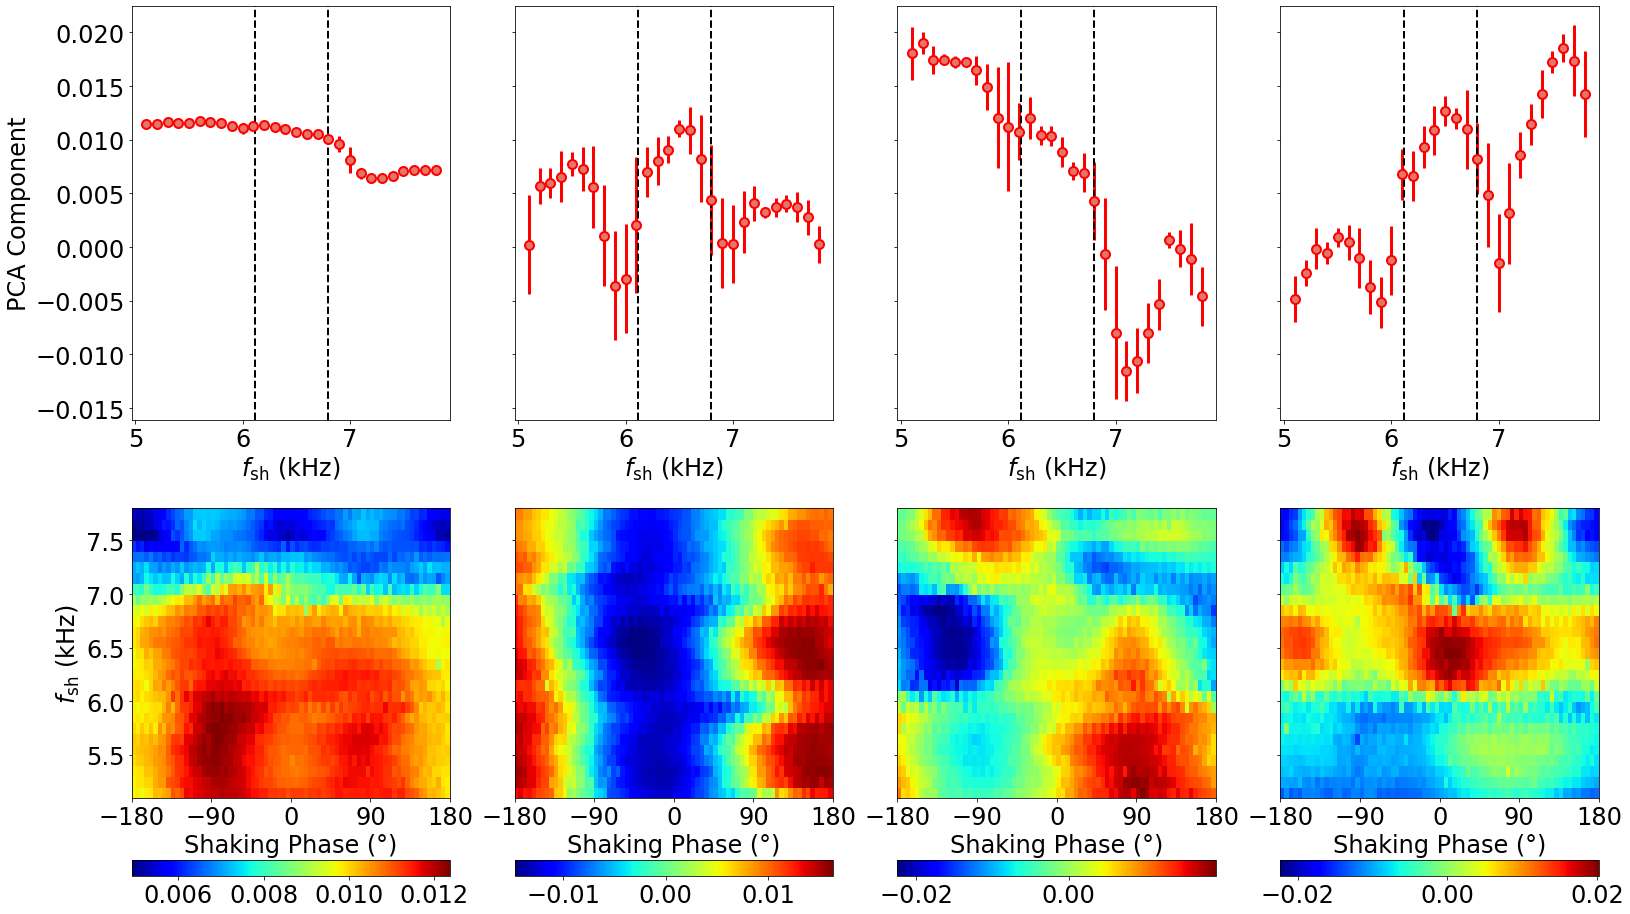

In [33]:
fig, axes = plt.subplots(2, len(components), figsize=[22, 14], sharey='row')
fig.tight_layout(h_pad=2)
for idx in range(len(components)):
    cdx = components[idx]
    mean_comp = []
    std_comp = []
    for ufreq in unique_freqs:
        selection_map_i = np.logical_and(parameter['phase'] == 90, parameter['freq'] == ufreq)
        mean_comp.append(np.mean(pca.components_[cdx, selection_map_i]))
        std_comp.append(np.std(pca.components_[cdx, selection_map_i]))
    axes[0, idx].errorbar(unique_freqs, mean_comp, yerr=std_comp)
    axes[0, idx].axvline(theory_low, ls='--', marker=None, color='black', ms=0, linewidth=2.0)
    axes[0, idx].axvline(theory_high, ls='--', marker=None, color='black', ms=0, linewidth=2.0)
    axes[0, idx].set_xlabel('$f_{\mathrm{sh}}$ (kHz)')
    axes[0, 0].set_ylabel('PCA Component')
    
    phase_diagram = np.zeros((unique_freqs.size, unique_phases.size))
    for idp in range(unique_phases.size):
        for idf in range(unique_freqs.size):
            selection_map_pd = np.logical_and(parameter['phase'] == unique_phases[idp],
                                           parameter['freq'] == unique_freqs[idf])
            phase_diagram[idf, idp] = np.mean(pca.components_[cdx, selection_map_pd])
    pcmesh = axes[1, idx].pcolormesh(unique_phases, unique_freqs, phase_diagram, cmap="jet", rasterized=True,
                   edgecolors='gray', linewidth=0)
    cx = plt.colorbar(pcmesh, ax=axes[1, idx], orientation='horizontal')
    axes[1, idx].set_xticks(phase_ticks)
    axes[1, idx].set_xlabel('Shaking Phase (°)')
    axes[1, 0].set_ylabel('$f_{\mathrm{sh}}$ (kHz)')
plt.savefig("plots/appendix/appendix_pca.pdf", bbox_inches='tight')